In [2]:
import numpy as np
import tensorflow as tf
import keras

from keras import layers, optimizers, losses
import matplotlib.pyplot as plt
import time


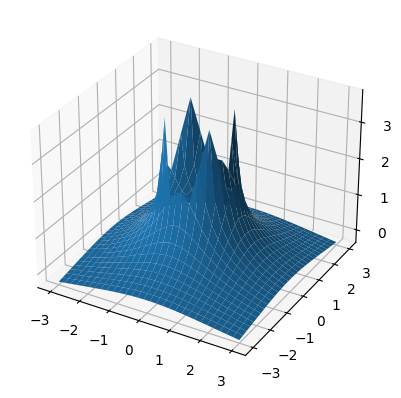

In [4]:
x = np.linspace(-3,3, 30)
y = np.linspace(-3,3, 30)
def log_3(r):
    if ( r <1):
        return np.nan
    else:
        return -np.log( (np.log(r) / np.log(3)) + 10e-4)


Z = np.zeros((30,30))
for i in range(30):
    for j in range(30):

        z = np.array([x[i],y[j]])
        Z[i,j] = log_3(np.linalg.norm(z)**2)

fig  = plt.figure()
ax = fig.add_subplot( projection = '3d')

X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,Z)

plt.show()

In [7]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from collections import deque
  # register PyBullet enviroments with open ai gym
import time
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

class SD3(object):
    def __init__(self, action_size, state_size):
        self.action_space = action_size
        self.state_space = state_size
        self.act_range = 1.0
        self.actor_opt = tf.keras.optimizers.Adam(lr=1e-3)
        self.critic_opt = tf.keras.optimizers.Adam(lr=1e-3)
        self.q1 = self.make_critic()
        self.q2 = self.make_critic()
        self.q1_target = self.make_critic()
        self.q2_target = self.make_critic()
        self.p1 = self.make_actor()
        self.p1_target = self.make_actor()
        self.p2 = self.make_actor()
        self.p2_target = self.make_actor()
        #self.policy.summary()
        #self.q1.summary()
        self.move_weights()
        self.buff = int(1e6)
        self.states = np.zeros((self.buff, self.state_space[0]))
        self.actions = np.zeros((self.buff, self.action_space[0]))
        self.rewards = np.zeros((self.buff, 1))
        self.dones = np.zeros((self.buff, 1))
        self.next_states = np.zeros((self.buff, self.state_space[0]))
        self.counter = 0
        self.batch = 100
        self.beta = 0.5
        self.gamma = 0.99 
        self.tau = 0.005
        self.p_noise = 0.2 * self.act_range
        self.t_noise = 0.5 * self.act_range
        self.noise_sample = 50
        self.mean = 0
        self.std = 0.1
     
    def make_critic(self):
        state_ = tf.keras.layers.Input(shape=(self.state_space[0]))
        action_ = tf.keras.layers.Input(shape=(self.action_space[0]))
        state = tf.keras.layers.Dense(256, activation='relu', name='state1')(state_)
        action = tf.keras.layers.Dense(64, activation='relu', name='act1')(action_)
        x = tf.keras.layers.Concatenate()([state, action])
        x = tf.keras.layers.Dense(256, activation='relu', name='dense2')(x)
        x = tf.keras.layers.Dense(256, activation='relu', name='dense3')(x)
        x = tf.keras.layers.Dense(1, name='output')(x)
        model = tf.keras.models.Model(inputs=[state_, action_], outputs=x)
        return model
    
    def make_actor(self):
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        state_ = tf.keras.layers.Input(shape=(self.state_space[0]))
        x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(state_)
        x = tf.keras.layers.Dense(512, activation='relu', name='dense2')(x)
        x = tf.keras.layers.Dense(128, activation='relu', name='dense3')(x)
        x = tf.keras.layers.Dense(self.action_space[0], activation='tanh', name='output', kernel_initializer=last_init)(x)
        x = x * self.act_range
        model = tf.keras.models.Model(inputs=state_, outputs=x)
        return model

    def remember(self, state, action, reward, next_state, _):
        i = self.counter % self.buff
        self.states[i] = state
        self.actions[i] = action
        self.rewards[i] = reward
        self.next_states[i] = next_state
        self.dones[i] = int(done)
        self.counter += 1

    def move_weights(self):
        self.q1_target.set_weights(self.q1.get_weights())
        self.q2_target.set_weights(self.q2.get_weights())
        self.p1_target.set_weights(self.p1.get_weights())
        self.p2_target.set_weights(self.p2.get_weights())

    def get_action(self, obs):
        obs = np.array([obs])
        act1 = self.p1(obs).numpy()
        act2 = self.p2(obs).numpy()
        val1 = tf.squeeze(self.q1([obs, act1])).numpy()
        val2 = tf.squeeze(self.q2([obs, act2])).numpy()
        action = act1 if val1 >= val2 else act2
        action = np.clip(action, -self.act_range, self.act_range)
        return action[0]
        #return [np.squeeze(action)]

    def train(self):
        self.update(self.p1, self.p1_target, self.q1, self.q1_target)
        self.update(self.p2, self.p2_target, self.q2, self.q2_target)

    def softmax_operator(self, qvals):
        max_q = tf.math.reduce_max(qvals, axis=1, keepdims=True)

        norm_q_vals = qvals - max_q
        e_beta_normQ = tf.math.exp(self.beta * norm_q_vals)
        Q_mult_e = qvals * e_beta_normQ

        numerators = Q_mult_e
        denominators = e_beta_normQ

        sum_numerators = tf.math.reduce_sum(numerators, axis=1)
        sum_denominators = tf.math.reduce_sum(denominators, axis=1)
        softmax_q_vals = sum_numerators / sum_denominators
        softmax_q_vals = tf.expand_dims(softmax_q_vals, axis=1)
        return softmax_q_vals


    def update(self, p, p_t, q, q_t):
        batch_indices = np.random.choice(min(self.counter, self.buff), self.batch)
        state_batch = tf.convert_to_tensor(self.states[batch_indices])
        action_batch = tf.convert_to_tensor(self.actions[batch_indices])
        reward_batch = tf.convert_to_tensor(self.rewards[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_states[batch_indices])
        dones_batch = tf.convert_to_tensor(self.dones[batch_indices])
        dones_batch = tf.cast(dones_batch, dtype=tf.float32)
        # Train critic
        with tf.GradientTape(persistent=True) as tape:
            next_action = p_t(next_state_batch)
            next_action = tf.expand_dims(next_action, axis=1)
            noise = tf.random.normal((action_batch.shape[0], self.noise_sample, action_batch.shape[1]))
            noise *= self.p_noise
            noise = tf.clip_by_value(noise, -self.t_noise, self.t_noise)
            next_action = tf.clip_by_value(noise + next_action, -self.act_range, self.act_range)
            next_state = tf.expand_dims(next_state_batch, axis=1)
            next_state = tf.repeat(next_state, repeats=[self.noise_sample], axis=1)


            next_Q1 = self.q1_target([next_state, next_action])
            next_Q2 = self.q2_target([next_state, next_action])
            next_Q = tf.math.minimum(next_Q1, next_Q2)
            next_Q = tf.squeeze(next_Q)

            softmax_next_Q = self.softmax_operator(next_Q)
            next_Q = softmax_next_Q
            target_Q = reward + (1 - dones_batch) * self.gamma * next_Q
            current_Q = q([state_batch, action_batch], training=True)
            msbe = tf.math.reduce_mean(tf.math.square(current_Q - target_Q))
            current_act = p(state_batch)
            policy_loss = -q([state_batch, current_act])
        
        critic_gradients = tape.gradient(msbe, q.trainable_variables)
        self.critic_opt.apply_gradients(zip(critic_gradients, q.trainable_variables))
        policy_gradients = tape.gradient(policy_loss, p.trainable_variables)
        self.actor_opt.apply_gradients(zip(policy_gradients, p.trainable_variables))

        self.update_target(p_t.trainable_variables, p.trainable_variables)
        self.update_target(q_t.trainable_variables, q.trainable_variables)
    
    @tf.function
    def update_target(self, target_weights, weights):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * self.tau + a * (1 - self.tau))

# Hyperparameters
steps = int(1e6)
#steps = 50000
windows = 50
learn_delay = int(1e4)
#learn_delay = 1000
#learn_delay = 100
minn = -1
maxx = 1

start = time.time()
env = gym.make("Pendulum-v1")
#env = gym.make("HumanoidFlagrunPyBulletEnv-v0")
'''env.observation_space.shape'''
print(env.action_space, env.action_space.shape)
print(env.observation_space, env.observation_space.shape)
#input()
agent = SD3(env.action_space.shape, env.observation_space.shape)
rewards = []
avg_reward = deque(maxlen=steps)
best_avg_reward = -math.inf
rs = deque(maxlen=windows)
i = 0
step = 0
while True:
    s1 = env.reset()
    total_reward = 0
    done = False
    while not done:
        #env.render()
        if step < learn_delay:
            action = (maxx - minn) * np.random.random(env.action_space.shape) + minn
        else:
            action = agent.get_action(s1)
        s2, reward, done, info = env.step(action)
        total_reward += reward
        agent.remember(s1, action, reward, s2, done)
        if agent.counter > learn_delay:
            agent.train()
        s1 = s2
        step += 1
    rs.append(total_reward)
    avg = np.mean(rs)
    avg_reward.append(avg)
    if avg > best_avg_reward:
        best_avg_reward = avg
    
    print("\rStep {}/{} Iteration {} || Best average reward {}, Current Average {}, Current Iteration Reward {}".format(step, steps, i, best_avg_reward, avg, total_reward), end='', flush=True)
    i += 1
    if step >= steps:
        break

print(time.time() - start)
#np.save("rewards", np.asarray(rewards))
#np.save("double_pen_sd3_0", np.asarray(avg_reward))
plt.plot(rewards, color='olive', label='Reward')
plt.plot(avg_reward, color='red', label='Average')
plt.legend()
#plt.title("Lunar Lander")
plt.ylabel('Reward')
plt.xlabel('Step')
plt.show()

DependencyNotInstalled: No module named 'mujoco_py'. (HINT: you need to install mujoco_py, and also perform the setup instructions here: https://github.com/openai/mujoco-py/.)

In [7]:
class experience_memory():

    def __init__(self, buffer_capacity, batch_size, state_dim, action_dim):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, state_dim), dtype=np.float32)
        self.action_buffer = np.zeros((self.buffer_capacity, action_dim), dtype=np.int32)
        self.reward_buffer = np.zeros((self.buffer_capacity, 1), dtype=np.float32)
        self.next_state_buffer = np.zeros((self.buffer_capacity, state_dim), dtype=np.float32)
        self.done_buffer = np.zeros((self.buffer_capacity, 1), dtype=np.float32)

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]


        self.buffer_counter += 1

class MountainCar():

    def __init__(self):
        
        self.env = gym.make("CartPole-v1")

        self.batch_size = 32
        self.max_memory_size = 500000

        self.state_dim = 4
        self.action_dim = 1

        self.gamma = 0.99
        self.tau = 0.001
        self.lower_action_bound = -1
        self.upper_action_bound = 1

        self.action_space = np.array([0,1])
        self.num_a = len(self.action_space)

        self.buffer = experience_memory(self.max_memory_size, self.batch_size, self.state_dim, self.action_dim)

        # init the neural netsf
        self.critic = self.get_critic_NN()
        self.target_critic = self.get_critic_NN()
        self.target_critic.set_weights(self.critic.get_weights())
        self.eps = 1
        self.alpha = 0.001
        self.critic_optimizer = tf.keras.optimizers.Adam(self.alpha)

    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
             
        
        next_q_vals =  self.target_critic(next_state_batch)
            
        target_vals = tf.reshape(tf.reduce_max(next_q_vals, axis =1),[self.batch_size,1])
        y = reward_batch + (1-done_batch)* self.gamma*target_vals
        y = tf.reshape(y,[self.batch_size,])
        mask = tf.reshape(tf.one_hot(action_batch, self.num_a, dtype=tf.float32),[self.batch_size, self.num_a])
        with tf.GradientTape() as tape:
            
            critic_value = self.critic(state_batch)
      
            critic_pred = tf.reduce_sum(tf.multiply(critic_value,mask), axis=1)
          
            #critic_loss = tf.reduce_mean(tf.math.square(y-critic_value))
            critic_loss = losses.MSE(y,critic_pred)
        
        
        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        critic_grad, _ = tf.clip_by_global_norm(critic_grad, 2.0)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        
    def learn(self):
        # get sample

        record_range = min(self.buffer.buffer_counter, self.buffer.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)
        
        state_batch = tf.convert_to_tensor(self.buffer.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.buffer.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.buffer.reward_buffer[batch_indices])
        next_state_batch = tf.convert_to_tensor(self.buffer.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.buffer.done_buffer[batch_indices])
        
        self.update(state_batch, action_batch, reward_batch, next_state_batch,done_batch)

    @tf.function
    def update_target(self, target_weights, weights):
        for (a,b) in zip(target_weights, weights):
            a.assign(self.tau *b + (1-self.tau) *a)

    def get_critic_NN(self):
        # input [state, action]
        
        state_input = layers.Input(shape =(self.state_dim,))

        out = layers.Dense(32, activation = 'relu')(state_input)
        out = layers.BatchNormalization()(out)
        out = layers.Dense(32, activation = 'relu')(out)
        out = layers.Dense(self.num_a)(out)

        
        model = keras.Model(inputs = state_input, outputs = out)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanSquaredError()],
        )
        return model

    def epsilon_greedy(self, state, eps):

        q_vals = self.critic(state)
        
        if (eps > np.random.rand()):
           
            rand_ind = np.random.choice(self.num_a)
            
            return self.action_space[rand_ind]
        
        else:
            
            a_ind = tf.argmax(q_vals,axis = 1)[0]
            
            return self.action_space[a_ind]
    
    def run_MC(self):
        done = False
        state = self.env.reset()
        state = tf.expand_dims(tf.convert_to_tensor(state),0)
        t_counter = 0
        while (True):
            self.env.render()
            time.sleep(0.01)
            
            a_ind = np.argmax(self.critic(state))
            
            action = self.action_space[a_ind]
            new_state, reward, done, info = self.env.step(action)
        
            new_state = tf.expand_dims(tf.convert_to_tensor(new_state.reshape(self.state_dim)),0)
            state = new_state
            t_counter += 1

            if (done):
                break
        print('Zeit: ', t_counter)
        

In [3]:
MC = MountainCar()

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
num_episode = 5000
decay = 0.9999
for ep in range(num_episode):
    
    done = False
    state = MC.env.reset()
    #state = tf.expand_dims(tf.convert_to_tensor(state),0)
    
    state = np.reshape(state, [1,MC.state_dim])
    episodic_reward = 0
    t_counter = 0

    #if (ep % 100 == 0 and ep != 0):
        #MC.run_MC()
    while(t_counter < 200):
        MC.alpha = 0.0001  #np.max([0.0001,0.01 * (1 / (1 +ep))])
        MC.eps = np.max([0.01, MC.eps * decay])
        action = MC.epsilon_greedy(state, MC.eps)
        
        new_state, reward, done, info = MC.env.step(action)
        
        #new_state = tf.expand_dims(tf.convert_to_tensor(new_state.reshape(MC.state_dim)),0)
       
        new_state = np.reshape(new_state, [1,MC.state_dim])
        episodic_reward += reward
        
        MC.buffer.record((state,action,reward, new_state, done))
       
        MC.learn()
    
        MC.update_target(MC.target_critic.variables, MC.critic.variables)

        state = new_state
        t_counter +=1
        if (done):
            break
    ep_reward_list.append(episodic_reward)
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-20:])
    print("Episode * {} * AVG Reward is ==> {}, eps ==> {}".format(ep, avg_reward, MC.eps))
    avg_reward_list.append(avg_reward)
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()



(array([ 0.03865113, -0.0289197 ,  0.0269503 , -0.02833511], dtype=float32), {})


d:\Users\pillieri\Desktop\Visual Studio Code Projekte\Python Projekte\.venv\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: cannot reshape array of size 2 into shape (1,4)